# GO Analysis of DGE and DAS genes
This notebook takes the output files from Ontologizer and searches for GO terms that are found to be significant in multiple tissues. It uses seaborn to make a heat plot for both differentially expressed (DGE) and differentially spliced (DAS) genes.

In [1]:
import os
import csv
from os import listdir
from os.path import isfile, join
from collections import defaultdict
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Paths
The notebook expects to find the 39 Ontologizer output files for DGE in one directory, the 39 
Ontologizer output files for DAS in another directory, and also uses the tissues.tsv files 
(which is in the assets directory).

Change the following paths to run this on lifebit.

In [2]:
# in assets on lifebit, map between GTEx names and display names
tissues_file = '/home/peter/GIT/sbasManuscript/sandbox/tissues.tsv' 
# directory containing the Ontologizer output files for DAS genes
base_dir_das = '/home/peter/Downloads/table-all_as_types'
# directory containing the Ontologizer output files for DGE genes
base_dir_dge = '/home/peter/Downloads/dge/DGE_ontologizer_inputs_results'

## 1) Get a list of display names for the GTEx tissue names
Store the values in ``tissues2display``. This transforms e.g. ``brain_frontal_cortex_ba_9`` to ``Frontal cortex``

In [3]:
tissues2display = defaultdict(str)
with open(tissues_file) as tf:
    csv_reader = csv.reader(tf, delimiter='\t')
    next(csv_reader) # ship header
    for row in csv_reader:
        if len(row) != 5:
            raise ValueError("Bar row") #should never happen
        name = row[0]
        if row[3] == '0':
            continue
        display_name = row[4]
        tissues2display[name] = display_name
print("We extracted %d display tissues" % len(tissues2display))

We extracted 39 display tissues


## 2) Differentially spliced genes
This notebook expects to have as input output files of the Ontologizer, one for each of the 39 tissues.
It identifies GO terms that are found to be significant in multiple tissues and then plots these GO terms
as a matrix. The following section of the notebook does the analysis for differentially splice genes, and further below we do the analysis with differentially expressed genes (DGE).

In [4]:
das_ontologizer_files = [f for f in listdir(base_dir_das) if isfile(join(base_dir_das, f)) if f.startswith("table")]
print("We got %d Ontologizer files." % len(das_ontologizer_files))

We got 39 Ontologizer files.


In [5]:
# Utility function that extracts e.g., heart_atrial_appendage
# from
# table-all_as_types_heart_atrial_appendage_AS_model_B_sex_as_events_gene_set-Term-For-Term-Benjamini-Hochberg.txt
def as_file_to_tissue_label(fname):
    if not 'table-all_as_types_' in fname:
        raise ValueError("Bad file name " + fname)
    tname = fname.split('table-all_as_types_')[1]
    if not '_AS_model_B_' in tname:
        raise ValueError("Bad tname format" + tname)
    tname = tname.split('_AS_model_B_')[0]
    return(tname)

In [6]:
def extract_significant_terms(f, dir, tissue_name):
    """
    Extract terms from the Ontologizer output files with adjusted p-values <0.05
    Field structure:
    ID	Pop.total	Pop.term	Study.total	Study.term	p	p.adjusted	p.min	name
    """
    path = os.path.join(dir, f)
    first = True
    sig_results = []
    with open(path) as fh:
        for line in fh:
            if first:
                first = False
                continue
            fields = line.rstrip("\n").split("\t")
            if len(fields) != 9:
                raise ValueError("Bad Line: " + line)
            ID = fields[0]
            padj = float(fields[6])
            if padj > 0.05:
                continue
            label = fields[8].replace("\"","")
            logp = -1 * math.log10(padj)
            if padj >0.05:
                logp = 0
            sig_results.append([ID, label, tissue_name, padj, logp])
    return sig_results

## Extract all significant GO terms for DAS

In [7]:
all_results = []

for f in das_ontologizer_files:
    tissue_name = as_file_to_tissue_label(f)
    res = extract_significant_terms(f, base_dir_das, tissue_name)
    all_results.extend(res)
    
print("We got a total of %d significant terms" % len(all_results))

We got a total of 1257 significant terms


In [8]:
df = pd.DataFrame(all_results, columns = ['id', 'label', 'tissue', 'padj', 'logp']) 

In [9]:
df.head()

,id,label,tissue,padj,logp
0,GO:0045948,positive regulation of translational initiation,heart_atrial_appendage,0.04248,1.371813
1,GO:0031369,translation initiation factor binding,heart_atrial_appendage,0.04248,1.371813
2,GO:0140457,protein demethylase activity,heart_atrial_appendage,0.04248,1.371813
3,GO:0032452,histone demethylase activity,heart_atrial_appendage,0.04248,1.371813
4,GO:0070076,histone lysine demethylation,heart_atrial_appendage,0.04248,1.371813


In [10]:
# Now count up how many times we see each GO term and remove below threshold GO terms
DAS_THRESHOLD = 4
df['freq'] = df.groupby('id')['id'].transform('count')
df.head()

,id,label,tissue,padj,logp,freq
0,GO:0045948,positive regulation of translational initiation,heart_atrial_appendage,0.04248,1.371813,1
1,GO:0031369,translation initiation factor binding,heart_atrial_appendage,0.04248,1.371813,1
2,GO:0140457,protein demethylase activity,heart_atrial_appendage,0.04248,1.371813,8
3,GO:0032452,histone demethylase activity,heart_atrial_appendage,0.04248,1.371813,8
4,GO:0070076,histone lysine demethylation,heart_atrial_appendage,0.04248,1.371813,8


In [11]:
df = df[df.freq > DAS_THRESHOLD]
df.head()

,id,label,tissue,padj,logp,freq
2,GO:0140457,protein demethylase activity,heart_atrial_appendage,0.04248,1.371813,8
3,GO:0032452,histone demethylase activity,heart_atrial_appendage,0.04248,1.371813,8
4,GO:0070076,histone lysine demethylation,heart_atrial_appendage,0.04248,1.371813,8
5,GO:0016577,histone demethylation,heart_atrial_appendage,0.04248,1.371813,8
6,GO:0006482,protein demethylation,heart_atrial_appendage,0.04248,1.371813,8


In [12]:
dfp = df.pivot(index='label', columns='tissue', values='logp')
dfp.fillna(0)
dfp

tissue,artery_coronary,brain_caudate_basal_ganglia,brain_nucleus_accumbens_basal_ganglia,colon_sigmoid,esophagus_muscularis,heart_atrial_appendage,heart_left_ventricle,muscle_skeletal,pancreas,whole_blood
label,,,,,,,,,,
demethylase activity,1.703703,2.309102,NaN,2.980119,1.669199,1.371813,1.702074,NaN,1.360382,2.105334
demethylation,1.440715,1.952583,NaN,2.521985,NaN,NaN,1.366048,1.787464,NaN,1.664600
dioxygenase activity,1.378899,1.887336,NaN,2.417579,NaN,NaN,1.302694,NaN,NaN,1.623614
histone demethylase activity,1.738436,2.335144,NaN,3.006226,1.853381,1.371813,1.727848,NaN,1.385965,2.131304
histone demethylation,1.738436,2.335144,NaN,3.006226,1.795294,1.371813,1.727848,NaN,1.385965,2.131304
histone lysine demethylation,1.738436,2.335144,NaN,3.006226,1.815154,1.371813,1.727848,NaN,1.385965,2.131304
histone methyltransferase complex,1.440715,1.921227,1.504479,2.495741,NaN,NaN,1.366048,NaN,NaN,1.623614
protein dealkylation,1.738436,2.335144,NaN,3.006226,1.795294,1.371813,1.727848,NaN,1.385965,2.131304
protein demethylase activity,1.738436,2.335144,NaN,3.006226,1.853381,1.371813,1.727848,NaN,1.385965,2.131304


In [13]:
mycolumns = []
for cname in dfp.columns:
    if cname in tissues2display:
        displayname = tissues2display[cname]
        mycolumns.append(displayname)
    else:
        mycolumns.append(cname)
dfp.columns = mycolumns
#dfp.columns

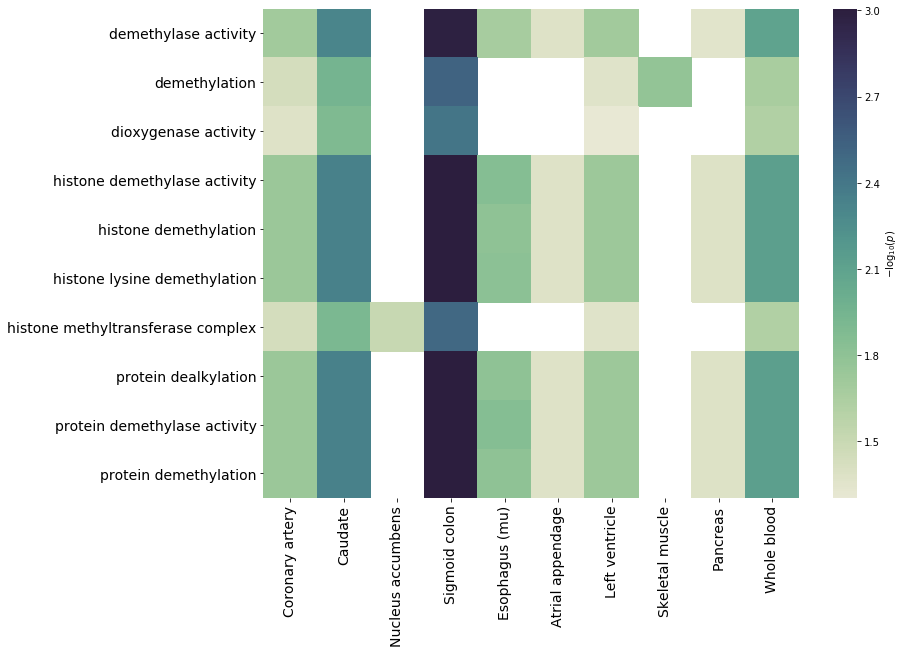

In [14]:
plt.rc('legend', fontsize=18)  
plt.subplots(figsize=(12,9))
cmap = sns.cubehelix_palette(as_cmap=True, start=.5, rot=-.75, light=.9)
ax = sns.heatmap(dfp, cmap=cmap)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(labelsize=14)
ax.collections[0].colorbar.set_label(r'$-\log_{10}(p)$')
plt.savefig('das-go-profile.pdf')

3) Differentially expressed genes

In [15]:
dge_ontologizer_files = [f for f in listdir(base_dir_dge) if isfile(join(base_dir_dge, f)) and f.startswith("table")]
print("We got %d Ontologizer DGE files." % len(dge_ontologizer_files))

We got 39 Ontologizer DGE files.


In [16]:
# Utility function that extracts e.g., heart_atrial_appendage
# from
# table-all_as_types_heart_atrial_appendage_AS_model_B_sex_as_events_gene_set-Term-For-Term-Benjamini-Hochberg.txt
def dge_file_to_tissue_label(fname):
    if not 'table' in fname:
        raise ValueError("Bad file name " + fname)
    tname = fname.split('table-')[1]
    if not '_geneset-Term-For-Term' in tname:
        raise ValueError("Bad tname format" + tname)
    tname = tname.split('_geneset-Term-For-Term')[0]
    return(tname)

## Extract all significant GO terms for DGE

In [17]:
all_results = []
for fname in dge_ontologizer_files:
    #dge_files.append(fname)
    tissue_name = dge_file_to_tissue_label(fname)
    res = extract_significant_terms(fname, base_dir_dge, tissue_name)
    all_results.extend(res)
    #print(tissue_name)
print("We extracted a total of %d GO terms" % len(all_results))

We extracted a total of 5735 GO terms


In [18]:
df = pd.DataFrame(all_results, columns = ['id', 'label', 'tissue', 'padj', 'logp']) 
df.head()

,id,label,tissue,padj,logp
0,GO:0140457,protein demethylase activity,artery_coronary,0.020321,1.69206
1,GO:0032452,histone demethylase activity,artery_coronary,0.020321,1.69206
2,GO:0070076,histone lysine demethylation,artery_coronary,0.020321,1.69206
3,GO:0071558,histone demethylase activity (H3-K27 specific),artery_coronary,0.020321,1.69206
4,GO:0071557,histone H3-K27 demethylation,artery_coronary,0.020321,1.69206


In [19]:
# Now count up how many times we see each GO term and remove below threshold GO terms
DGE_THRESHOLD = 10
df['freq'] = df.groupby('id')['id'].transform('count')
df.head()

,id,label,tissue,padj,logp,freq
0,GO:0140457,protein demethylase activity,artery_coronary,0.020321,1.69206,24
1,GO:0032452,histone demethylase activity,artery_coronary,0.020321,1.69206,24
2,GO:0070076,histone lysine demethylation,artery_coronary,0.020321,1.69206,24
3,GO:0071558,histone demethylase activity (H3-K27 specific),artery_coronary,0.020321,1.69206,28
4,GO:0071557,histone H3-K27 demethylation,artery_coronary,0.020321,1.69206,28


In [20]:
df = df[df.freq > DGE_THRESHOLD]
df.head()

,id,label,tissue,padj,logp,freq
0,GO:0140457,protein demethylase activity,artery_coronary,0.020321,1.69206,24
1,GO:0032452,histone demethylase activity,artery_coronary,0.020321,1.69206,24
2,GO:0070076,histone lysine demethylation,artery_coronary,0.020321,1.69206,24
3,GO:0071558,histone demethylase activity (H3-K27 specific),artery_coronary,0.020321,1.69206,28
4,GO:0071557,histone H3-K27 demethylation,artery_coronary,0.020321,1.69206,28


In [21]:
# Some top level terms that are omitted from the display
omitTerms = {'GO:0005575':'cellular_component',
            'GO:0000000' :'Gene Ontology',
             'GO:0008150':'biological_process',
             'GO:0003674': 'molecular_function'
            }
df = df[~df['id'].isin(omitTerms)]

In [22]:
dfp = df.pivot(index='label', columns='tissue', values='logp')
dfp.fillna(0)
dfp

tissue,adipose_subcutaneous,adipose_visceral_omentum,adrenal_gland,artery_coronary,artery_tibial,brain_caudate_basal_ganglia,brain_hypothalamus,brain_nucleus_accumbens_basal_ganglia,brain_putamen_basal_ganglia,breast_mammary_tissue,...,nerve_tibial,pancreas,pituitary,skin_not_sun_exposed_suprapubic,skin_sun_exposed_lower_leg,small_intestine_terminal_ileum,spleen,stomach,thyroid,whole_blood
label,,,,,,,,,,,,,,,,,,,,,
MLL3/4 complex,NaN,NaN,1.464874,NaN,NaN,NaN,1.607579,1.644053,NaN,NaN,...,1.655313,NaN,NaN,NaN,NaN,1.545245,1.343794,1.733269,NaN,NaN
biological regulation,28.495256,8.942239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.271311,...,6.481544,NaN,4.180883,2.950414,5.230845,NaN,NaN,NaN,14.409662,NaN
cellular anatomical entity,30.593755,4.882533,NaN,NaN,1.409952,NaN,NaN,NaN,NaN,64.169408,...,3.054906,NaN,5.309680,6.919165,5.595630,NaN,NaN,NaN,13.917571,NaN
cellular process,21.738353,4.884869,NaN,NaN,1.571913,NaN,NaN,NaN,NaN,36.333693,...,3.850844,NaN,3.207307,7.476408,6.944621,NaN,NaN,NaN,5.258745,NaN
demethylase activity,1.329164,1.406693,1.949157,1.517564,1.381315,1.884912,2.309919,2.306935,1.754491,NaN,...,2.003083,1.617534,NaN,NaN,NaN,2.202791,1.900126,2.323270,NaN,1.507764
demethylation,NaN,NaN,1.311336,NaN,NaN,NaN,1.566227,1.565091,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.461211,NaN,1.632813,NaN,1.715217
histone H3-K27 demethylation,1.474777,1.998460,2.145261,1.692060,1.486423,2.060247,2.398816,2.434902,1.929266,NaN,...,2.452532,1.797657,1.354473,NaN,NaN,2.336038,2.075228,2.414766,1.585899,1.715217
histone demethylase activity,NaN,1.714103,2.145261,1.692060,1.448681,2.060247,2.398816,2.434902,1.929266,NaN,...,2.365242,1.797657,NaN,NaN,NaN,2.336038,2.075228,2.414766,NaN,1.715217
histone demethylase activity (H3-K27 specific),1.474777,1.998460,2.145261,1.692060,1.486423,2.060247,2.398816,2.434902,1.929266,NaN,...,2.452532,1.797657,1.354473,NaN,NaN,2.336038,2.075228,2.414766,1.585899,1.715217


In [23]:
mycolumns = []
for cname in dfp.columns:
    if cname in tissues2display:
        displayname = tissues2display[cname]
        mycolumns.append(displayname)
    else:
        mycolumns.append(cname)
dfp.columns = mycolumns

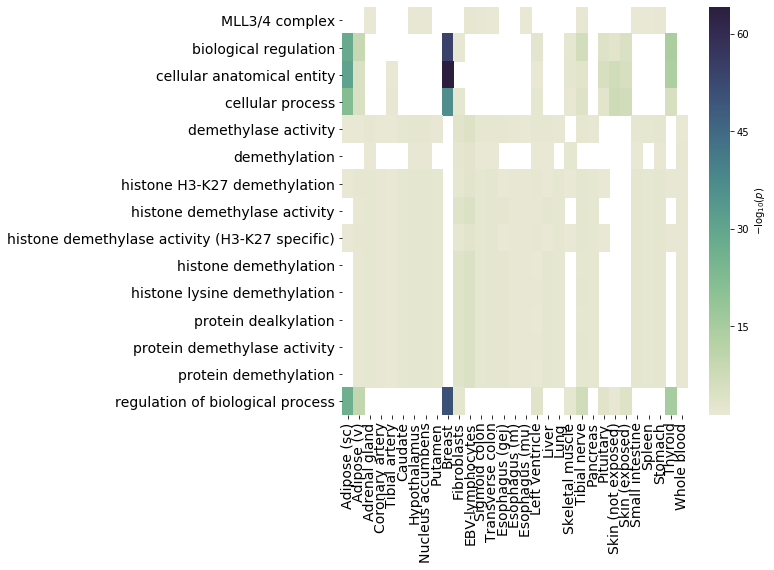

In [24]:
plt.rc('legend', fontsize=18)  
plt.subplots(figsize=(12,9))
cmap = sns.cubehelix_palette(as_cmap=True, start=.5, rot=-.75, light=.9)
ax = sns.heatmap(dfp, cmap=cmap)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(labelsize=14)
ax.collections[0].colorbar.set_label(r'$-\log_{10}(p)$')
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(left=0.4)
plt.savefig('dge-go-profile.pdf')